# Exploration of hormonal receptor genes in Castaldi et al organoid dataset - Metacell calculation by SeaCells

[Reference paper](https://doi.org/10.1038/s41592-024-02555-5)

__Upstream Steps__

* Assemble adata
* QC filter on cells; Expression filter on genes
* Normalization and log10 transformation by Scanpy functions
* Feature selection (HVG) by Scanpy functions
* Dimensionality reduction
* Cluster identification


__This Notebook__

Metacell calculation by SEACells (following [this tutorial](https://github.com/dpeerlab/SEACells/blob/main/notebooks/SEACell_computation.ipynb))


-----

# 1. Environment

## 1.1 Modules

In [3]:
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc

import pickle

#Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#utils
import ipynbname
from datetime import datetime

# SeaCell
import SEACells

#import custom functions
sys.path.append('../')
import functions as fn

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [3.5, 3.5]
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
print("Scanpy version: ", sc.__version__)
print("Pandas version: ", pd.__version__)
print("SEACell version: ", SEACells.__version__)

Scanpy version:  1.10.1
Pandas version:  2.2.2
SEACell version:  0.3.3


## 1.2 Settings


In [4]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

## 1.3 Files and parameters

In [5]:
path = '../../../../Castaldi_multiplexingCBO/'
input_file_raw = path + 'adataPagaRaw.h5ad'
input_file_processed = path + 'adataPaga.h5ad'

output_file = '../../../../DataDir/ExternalData/SingleCellData/CastaldiAdata_Metacells.h5ad'

## 1.4 Start computations

In [6]:
print(datetime.now())

2025-02-25 21:26:06.186437


----

# 2. Data Load


## 2.1 Read adata file

* SEACells uses as input filtered unnormalized counts from scRNASeq data, that are subjected to normalization and log-transformation before metacell assignment
* Here we start from data that has already undergone the steps of QC, filtering, normalization, log transformation
* The sum of expression levels from cells to metacells will occur at the count level  

In [7]:
adata_raw = sc.read(input_file_raw)

In [8]:
adata_raw

AnnData object with n_obs × n_vars = 14913 × 33538
    obs: 'dataset', 'cellID', 'cellID_newName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'stage', 'type', 'id_stage', 'cellID_newName_type', 'S_score', 'G2M_score', 'phase', 'leidenAnnotated', 'leiden_1.2', 'endpoint_GlutamatergicNeurons_late', 'endpoint_GlutamatergicNeurons_early', 'endpoint_MigratingNeurons', 'endpoint_OuterRadialGliaAstrocytes', 'endpoint_Interneurons', 'endpoint_Interneurons_GAD2', 'endpoint_CajalR_like', 'Exc_Lineage', 'endpoint_GlutamatergicNeurons_both'
    var: 'highly_variable'
    uns: 'cellID_colors', 'cellID_newName_colors', 'cellID_newName_type_colors', 'dataset_colors', 'stage_colors', 'type_colors'

In [9]:
print(adata_raw.X)

  (0, 21)	1.0
  (0, 32)	1.0
  (0, 51)	1.0
  (0, 55)	1.0
  (0, 66)	1.0
  (0, 74)	1.0
  (0, 77)	1.0
  (0, 78)	1.0
  (0, 86)	1.0
  (0, 91)	1.0
  (0, 132)	1.0
  (0, 153)	1.0
  (0, 154)	8.0
  (0, 161)	3.0
  (0, 178)	3.0
  (0, 190)	3.0
  (0, 198)	1.0
  (0, 201)	3.0
  (0, 220)	1.0
  (0, 226)	1.0
  (0, 228)	1.0
  (0, 229)	1.0
  (0, 240)	1.0
  (0, 244)	1.0
  (0, 257)	1.0
  :	:
  (14912, 33250)	1.0
  (14912, 33252)	1.0
  (14912, 33254)	3.0
  (14912, 33257)	1.0
  (14912, 33286)	1.0
  (14912, 33297)	2.0
  (14912, 33326)	6.0
  (14912, 33327)	1.0
  (14912, 33376)	2.0
  (14912, 33400)	1.0
  (14912, 33443)	1.0
  (14912, 33445)	2.0
  (14912, 33446)	3.0
  (14912, 33474)	1.0
  (14912, 33493)	1.0
  (14912, 33496)	9.0
  (14912, 33497)	17.0
  (14912, 33498)	35.0
  (14912, 33499)	26.0
  (14912, 33501)	22.0
  (14912, 33502)	23.0
  (14912, 33503)	7.0
  (14912, 33505)	19.0
  (14912, 33506)	5.0
  (14912, 33508)	8.0


In [10]:
adata_processed = sc.read(input_file_processed)

In [11]:
adata_processed

AnnData object with n_obs × n_vars = 14913 × 3499
    obs: 'dataset', 'cellID', 'cellID_newName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'stage', 'type', 'id_stage', 'cellID_newName_type', 'S_score', 'G2M_score', 'phase', 'leidenAnnotated', 'leiden_1.2', 'endpoint_GlutamatergicNeurons_late', 'endpoint_GlutamatergicNeurons_early', 'endpoint_MigratingNeurons', 'endpoint_OuterRadialGliaAstrocytes', 'endpoint_Interneurons', 'endpoint_Interneurons_GAD2', 'endpoint_CajalR_like', 'Exc_Lineage', 'endpoint_GlutamatergicNeurons_both'
    var: 'highly_variable', 'mean', 'std'
    uns: 'Exc_Lineage_colors', 'cellID_colors', 'cellID_newName_colors', 'cellID_newName_type_colors', 'cluster_colors', 'dataset_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'leidenAnnotated_colors', 'leiden_1.2_colors', 'leiden_1.2_sizes', 'leide

In [12]:
adata_processed.X

array([[-0.1101227 , -0.03764268, -0.10671675, ...,  1.0436227 ,
        -0.42106158,  0.94464684],
       [-0.10579659, -0.03393181, -0.09523427, ..., -1.614362  ,
        -0.34122995,  0.80248106],
       [-0.10780934, -0.0321864 , -0.0686875 , ..., -1.3371783 ,
         2.094029  ,  0.32830933],
       ...,
       [-0.10884036, -0.03099594, -0.05236688, ...,  1.4554093 ,
        -0.11861944, -0.20008735],
       [-0.10843779, -0.03006287, -0.04589986, ...,  0.5492132 ,
        -0.08165   ,  0.06683627],
       [-0.11309421, -0.03857994, -0.09980118, ...,  0.4531901 ,
        -0.39489594, -0.30604613]], dtype=float32)

In [13]:
print(adata_processed.X[40:45, 40:45])

[[-0.10693801 -0.2635417  -0.02182518 -0.21160652 -0.18656783]
 [-0.2791373  -0.42240766 -0.06116362 -0.21721914 -0.22796988]
 [-0.1187046  -0.28715882 -0.01146859 -0.21044183 -0.19139752]
 [-0.24716817 -0.39672074 -0.04996909 -0.2157153  -0.22088031]
 [-0.10508772 -0.26693517 -0.01618887 -0.21092744 -0.18692257]]


In [14]:
adata = adata_raw.copy()

adata.obsm['X_diffmap'] = adata_processed.obsm['X_diffmap'].copy()
adata.obsm['X_draw_graph_fa'] = adata_processed.obsm['X_draw_graph_fa'].copy()
adata.obsm['X_pca'] = adata_processed.obsm['X_pca'].copy()
adata.obsm['X_umap'] = adata_processed.obsm['X_umap'].copy()

In [15]:
adata.uns = adata_processed.uns.copy()

In [16]:
adata.layers['counts'] = adata.X.copy()

In [17]:
adata

AnnData object with n_obs × n_vars = 14913 × 33538
    obs: 'dataset', 'cellID', 'cellID_newName', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'stage', 'type', 'id_stage', 'cellID_newName_type', 'S_score', 'G2M_score', 'phase', 'leidenAnnotated', 'leiden_1.2', 'endpoint_GlutamatergicNeurons_late', 'endpoint_GlutamatergicNeurons_early', 'endpoint_MigratingNeurons', 'endpoint_OuterRadialGliaAstrocytes', 'endpoint_Interneurons', 'endpoint_Interneurons_GAD2', 'endpoint_CajalR_like', 'Exc_Lineage', 'endpoint_GlutamatergicNeurons_both'
    var: 'highly_variable'
    uns: 'Exc_Lineage_colors', 'cellID_colors', 'cellID_newName_colors', 'cellID_newName_type_colors', 'cluster_colors', 'dataset_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'leidenAnnotated_colors', 'leiden_1.2_colors', 'leiden_1.2_sizes', 'leiden_Filt_colors'

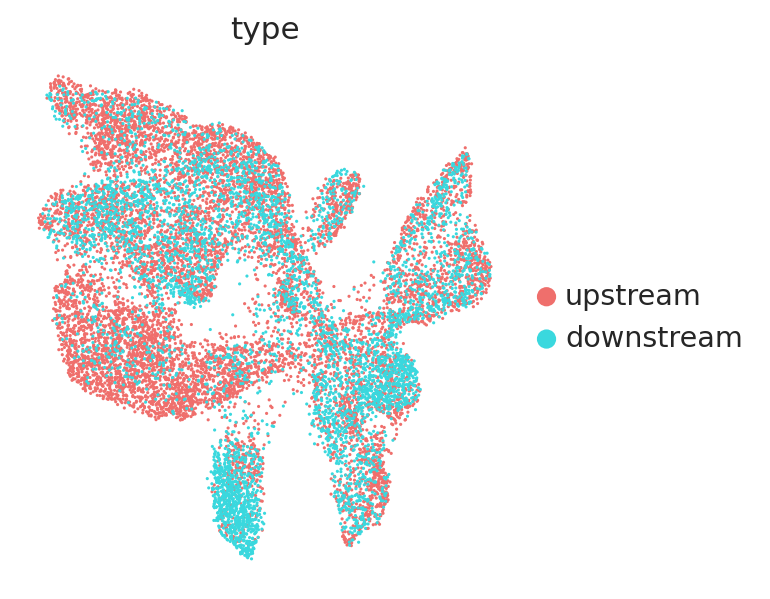

In [18]:
sc.pl.scatter(adata, basis='umap', color='type', frameon=False)

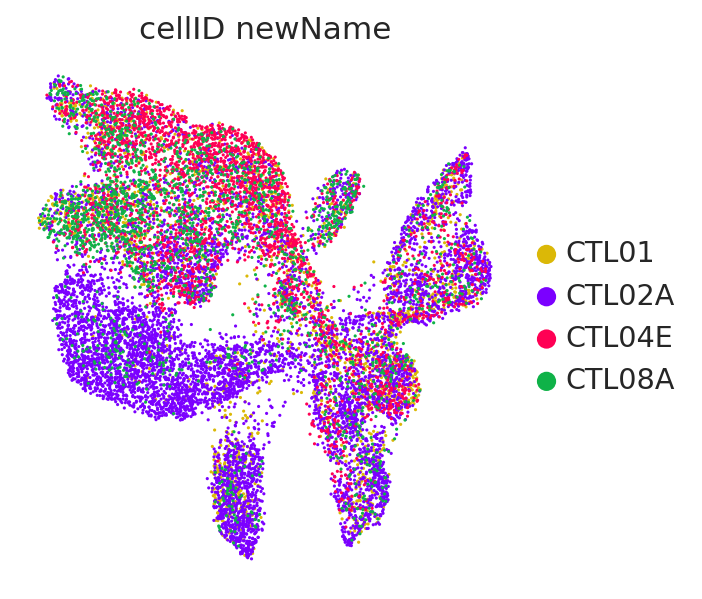

In [19]:
sc.pl.scatter(adata, basis='umap', color='cellID_newName', frameon=False)

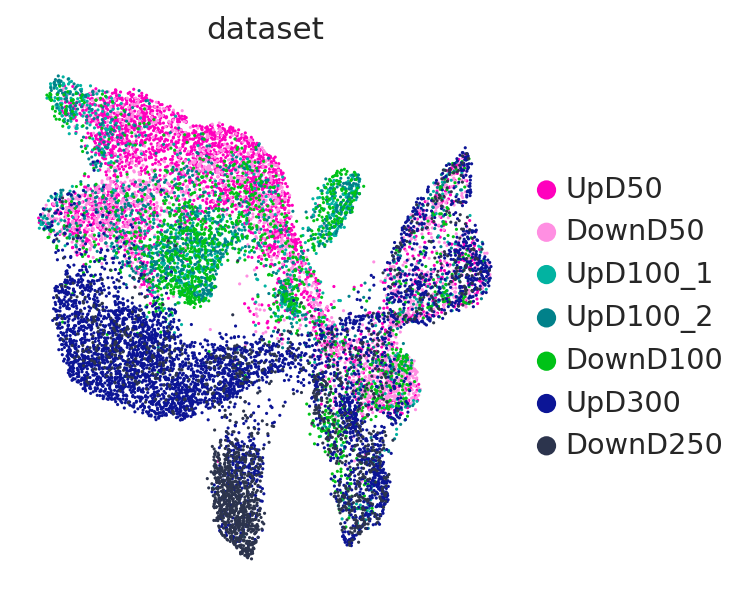

In [20]:
sc.pl.scatter(adata, basis='umap', color='dataset', frameon=False)

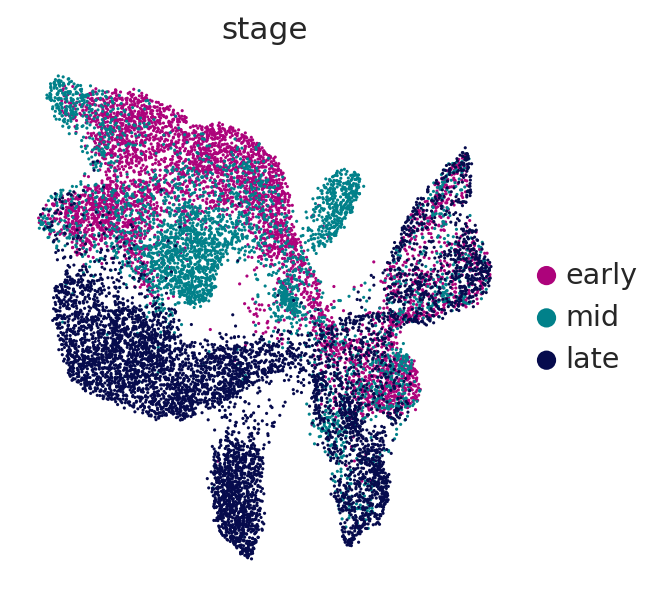

In [21]:
sc.pl.scatter(adata_processed, basis='umap', color='stage', frameon=False)

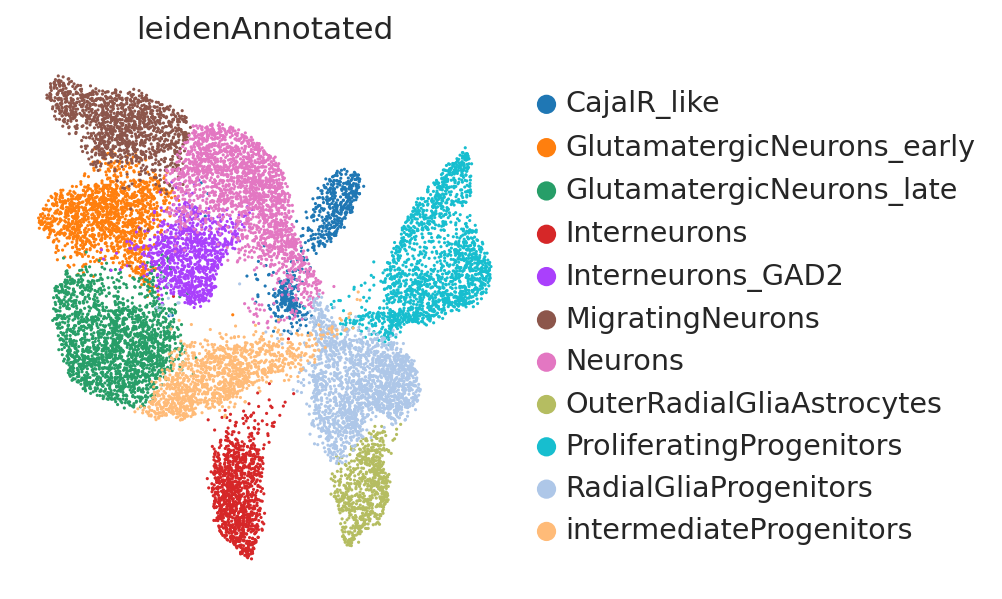

In [22]:
sc.pl.scatter(adata, basis='umap', color='leidenAnnotated', frameon=False)

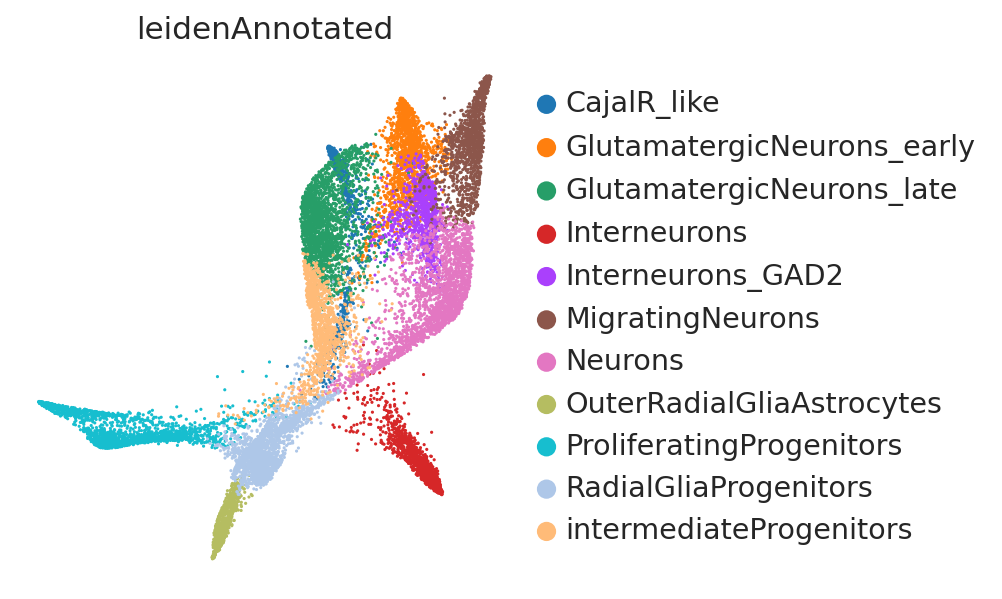

In [23]:
sc.pl.scatter(adata, basis='draw_graph_fa', color='leidenAnnotated', frameon=False)

In [24]:
adata.obs.head(3)

,dataset,cellID,cellID_newName,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,...,leiden_1.2,endpoint_GlutamatergicNeurons_late,endpoint_GlutamatergicNeurons_early,endpoint_MigratingNeurons,endpoint_OuterRadialGliaAstrocytes,endpoint_Interneurons,endpoint_Interneurons_GAD2,endpoint_CajalR_like,Exc_Lineage,endpoint_GlutamatergicNeurons_both
AAACCTGAGAGACTAT-1_DownD250,DownD250,MIFF1,CTL02A,2586,7.858254,6358.0,8.757627,175.0,5.170484,2.752438,...,0,1,0,0,0,0,0,0,GlutamatergicNeurons_late,1
AAACCTGCATGGTTGT-1_DownD250,DownD250,KOLF,CTL08A,1372,7.224753,2540.0,7.840313,73.0,4.304065,2.874016,...,0,1,0,0,0,0,0,0,GlutamatergicNeurons_late,1
AAACCTGTCAGTTAGC-1_DownD250,DownD250,3391B,CTL01,1216,7.104144,2859.0,7.958577,43.0,3.784190,1.504022,...,6,0,0,0,0,1,0,0,Other,0


## 2.2 Pre-processing

Normalization, log-transformation, HVG and dimensionality reduction have been already performed.

# 3. Run SEACells

We follow the workflow described in the [SEACells tutorial](https://github.com/dpeerlab/SEACells/blob/main/notebooks/SEACell_computation.ipynb)



## 3.1 Define parameters

Parameters to be defined: 

* __Number of metacells__ (graining level): choosing one metacell for every 60 single-cells.
* __X_pca__ as the key in .obsm for computing in metacells (to be changed to X_svd in case od ATAC data)
* __Number of eigenvalues__ for metacell initialization

We then employ the __SEACells.core.SEACells__ function to initialize the model. 

In [25]:
## Core parameters 
n_SEACells = round(adata.n_obs/60)
print(n_SEACells)

build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

249


In [26]:
#help(SEACells.core.SEACells)

model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


## 3.2 Construct kernel matrix 

[__construct_kernel_matrix__](https://github.com/dpeerlab/SEACells/blob/main/SEACells/cpu.py) function constructs the kernel matrix from data matrix using PCA/SVD and nearest neighbors. Key parameters are: 

* n_neighbors: (int) number of nearest neighbors to use for graph construction (default 15). Increasing this number results in a more homogeneous distribution of metacell size, but may impact on the preservation of rare cell types. Usually stable performance in the range 5-30. 
* graph_construction: method for graph construction.

In [27]:
model.construct_kernel_matrix(n_neighbors=20)
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:55)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/14913 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/14913 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/14913 [00:00<?, ?it/s]

Constructing CSR matrix...


## 3.3 Initialize archetypes

* [__initialize_archetypes__](https://github.com/dpeerlab/SEACells/blob/main/SEACells/cpu.py) function initializes the B matrix which defines cells as SEACells.
* The function uses waypoint analysis for initialization into to fully cover the phenotype space, and then greedily selects the remaining cells.


In [28]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
Done.
Sampling waypoints ...
Done.
Selecting 235 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 24/24 [00:00<00:00, 41.82it/s]

Selecting 14 cells from greedy initialization.


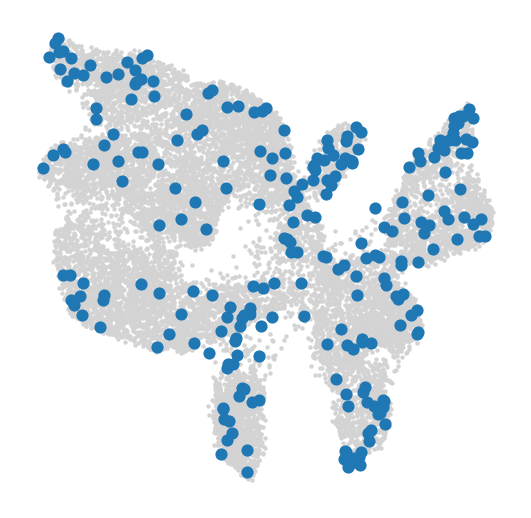

In [29]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata, model)

## 3.4 Fit Model

We apply the __model.fit__ function. 

In [30]:
model.fit(min_iter=10, max_iter=100)
model

Randomly initialized A matrix.
Setting convergence threshold at 0.00235
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 21 iterations.


## 4. Access SEACells results 

### 4.1 Check model convergence

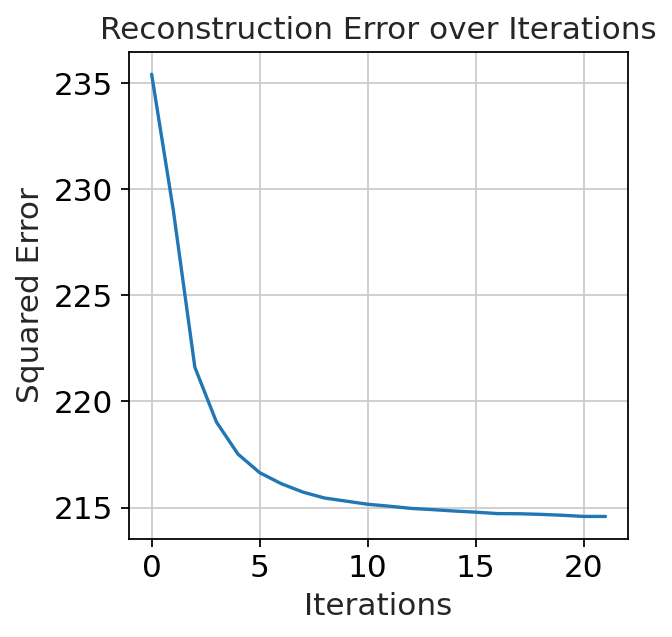

In [31]:
# Plot model convergence
model.plot_convergence()

### 4.2 Inspect SEACells soft assignment

* SEACells analysis returns soft assignments of cells to SEACells (full assignment matrix can be accessed at model.A_)
* The majority of single-cells are assigned to no more than 4 archetypes with non-trivial weight
* The algorithm returns the top 5 metacell assignments as well as the corresponding assignment weights in the function __model.get_soft_assignments()__


/tmp/ipykernel_37687/2880491417.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


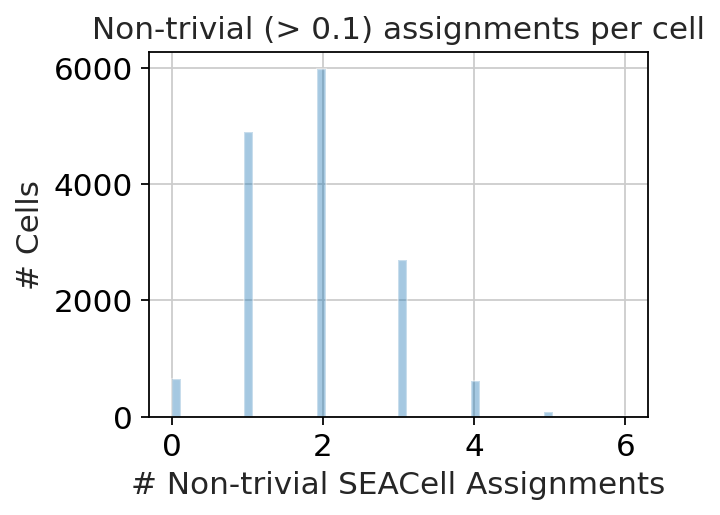

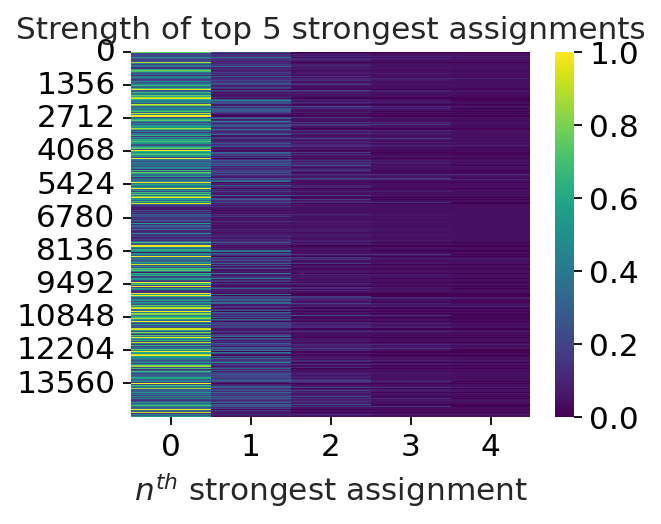

In [32]:
#model.A_

plt.figure(figsize=(4,3))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

plt.figure(figsize=(4,3))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()

In [33]:
labels,weights = model.get_soft_assignments()
#labels.head()

### 4.3 Inspect and retrieve SEACells hard assignment

We will use hard assignment of each cell to a single metacell to define our metacells for downstream steps. Hard assingment can be retreived in two ways:

* in the modified anndata object in .obs['SEACell']
* from the model using .get_hard_assignments()


In [34]:
adata.obs[['SEACell']].head()

# Alternatively: 
# model.get_hard_assignments().head()

,SEACell
index,
AAACCTGAGAGACTAT-1_DownD250,SEACell-208
AAACCTGCATGGTTGT-1_DownD250,SEACell-232
AAACCTGTCAGTTAGC-1_DownD250,SEACell-243
AAACGGGCAGCTATTG-1_DownD250,SEACell-175
AAACGGGGTGCACGAA-1_DownD250,SEACell-81


## 5. Summarizing data by hard assignment

* The original dataset can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell.  
* The output of this function is an anndata object of shape n_metacells x original_data_dimension.
* Data is unnormalized and raw aggregated counts are stored in X.
* Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

In [35]:
# By default, ad.raw is used for summarization. Other layers present in the anndata can be specified using the parameter summarize_layer parameter
SEA_adata = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='counts', celltype_label='leidenAnnotated')
SEA_adata

100%|██████████| 249/249 [00:01<00:00, 150.11it/s]


AnnData object with n_obs × n_vars = 249 × 33538
    obs: 'leidenAnnotated', 'leidenAnnotated_purity'
    layers: 'raw'

In [36]:
SEA_adata.obs.head()

,leidenAnnotated,leidenAnnotated_purity
SEACell-208,GlutamatergicNeurons_late,1.000000
SEACell-232,GlutamatergicNeurons_late,0.987952
SEACell-243,Interneurons,1.000000
SEACell-175,Interneurons,0.961538
SEACell-81,RadialGliaProgenitors,1.000000


In [37]:
print(SEA_adata.X[40:43, 40:43])

  (0, 0)	4.0
  (1, 0)	11.0
  (2, 0)	4.0


## 7. Visualize results

* __plot_2D()__:  visualize metacell assignments on UMAP or any 2-dimensional embedding froma adata.obsm. Plots can also be coloured by metacell assignment. The visualization allows to assess the __representativeness__ of the calculated metacells: ability to represent the global structure of the original dataset. Better representation corresponds to a more uniform coverage of the dataset.

* __plot_SEACell_sizes()__: distribution of number of cells assigned to each metacell. Given to the non-uniform distribution of cell type density, metacells are expected to vary in size: larger metacells are retrieved from denser regions, and smaller metacells from sparser ones. However outlier values may require further inspection. 



/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


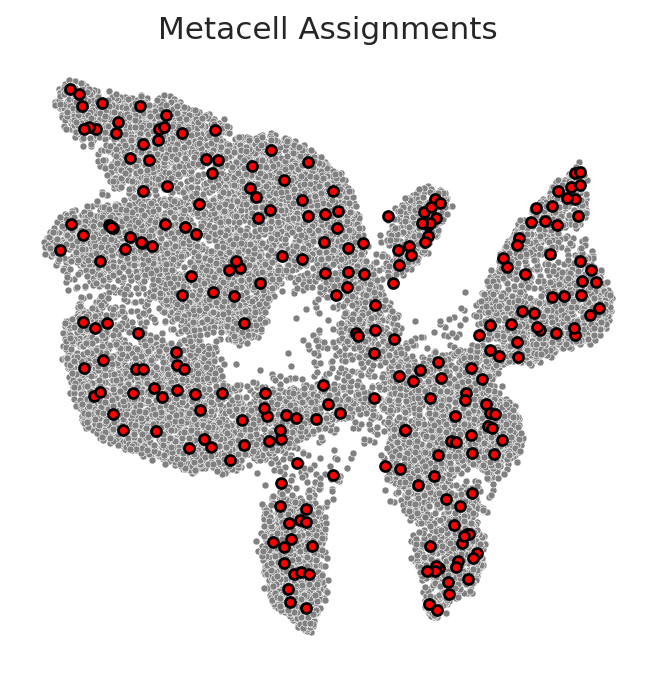

In [38]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=False)

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


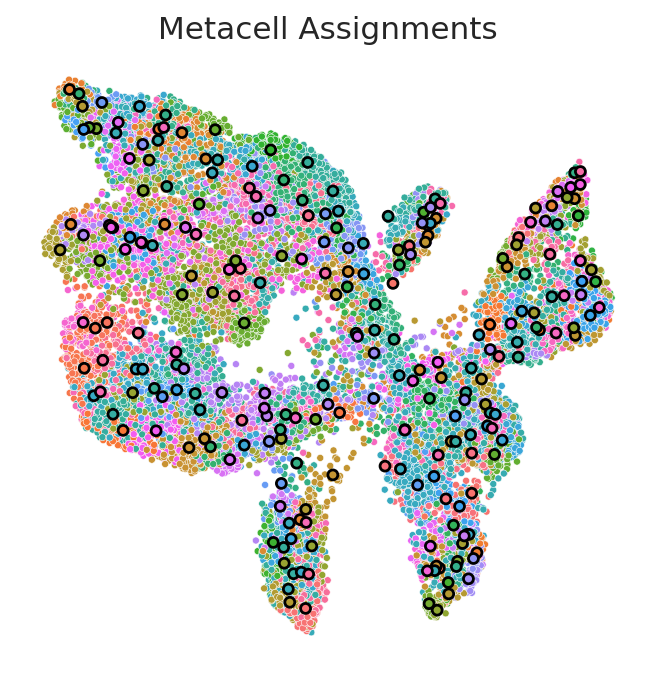

In [39]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=True)

/usr/local/lib/python3.10/dist-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


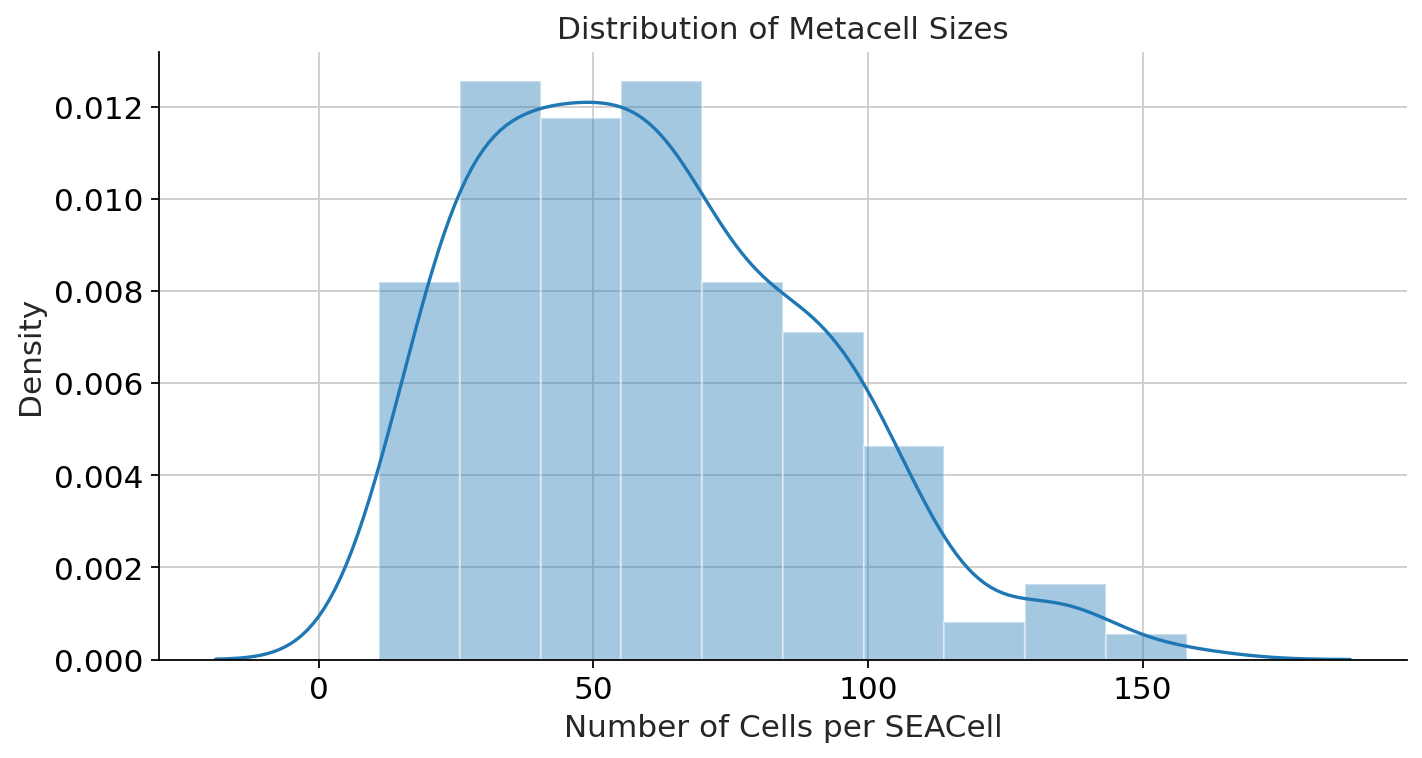

,size
SEACell,
SEACell-0,134
SEACell-1,65
SEACell-10,33
SEACell-100,51
SEACell-101,49
...,...
SEACell-95,91
SEACell-96,70
SEACell-97,43


In [40]:
SEACells.plot.plot_SEACell_sizes(adata, bins=10, figsize=(10, 5))

## 8. Quantifying results

* __Purity__: compute_celltype_purity(ad, col_name) computes the purity of different celltype labels within a SEACell metacell. 
  
* __Compactness__: per-SEAcell variance in diffusion components (typically 'X_pca' for RNA). Lower values of compactness suggest more compact/lower variance metacells.

* __Separation__: distance between a SEACell and its nth_nbr. If cluster is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value. Higher values of separation suggest better distinction between metacells. 

### 8.1 Purity

#### Cell Population

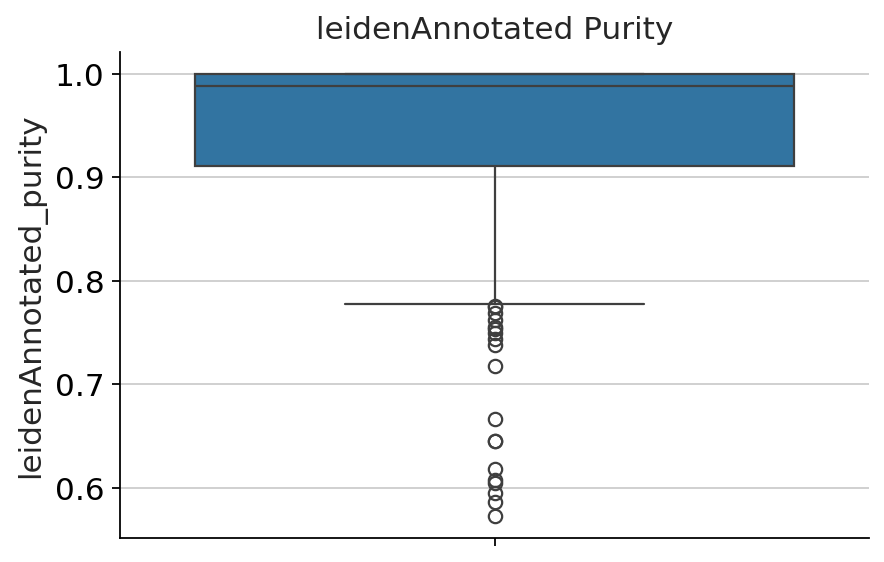

,leidenAnnotated,leidenAnnotated_purity
SEACell,,
SEACell-0,Interneurons_GAD2,0.970149
SEACell-1,RadialGliaProgenitors,1.000000
SEACell-10,CajalR_like,1.000000
SEACell-100,RadialGliaProgenitors,0.862745
SEACell-101,OuterRadialGliaAstrocytes,0.775510


In [41]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(adata, 'leidenAnnotated')

plt.figure(figsize=(6,4))
sns.boxplot(data=SEACell_purity, y='leidenAnnotated_purity')
plt.title('leidenAnnotated Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

### 8.2 Compactness

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


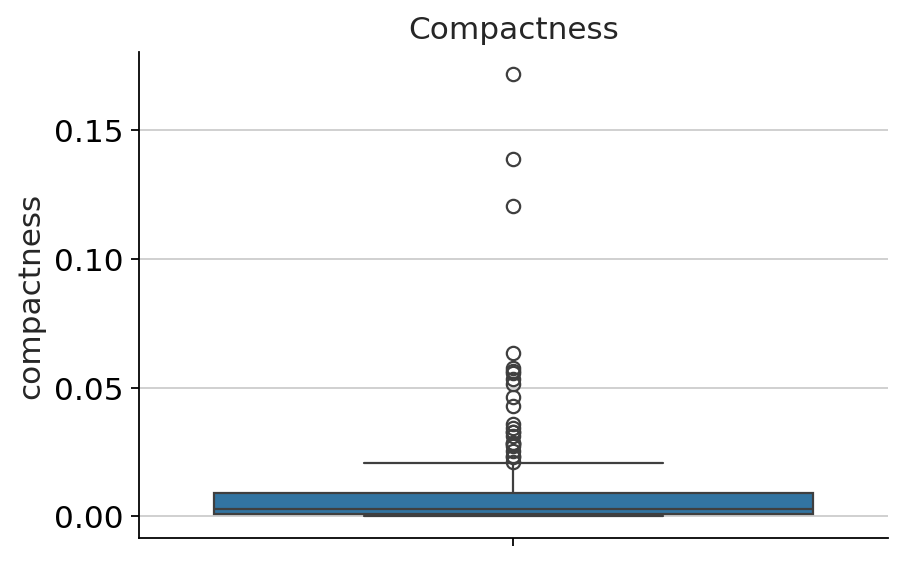

,compactness
SEACell,
SEACell-0,0.001914
SEACell-1,0.000711
SEACell-10,0.031246
SEACell-100,0.003786
SEACell-101,0.011894


In [42]:
compactness = SEACells.evaluate.compactness(adata, 'X_pca')

plt.figure(figsize=(6,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

### 8.3 Separation

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


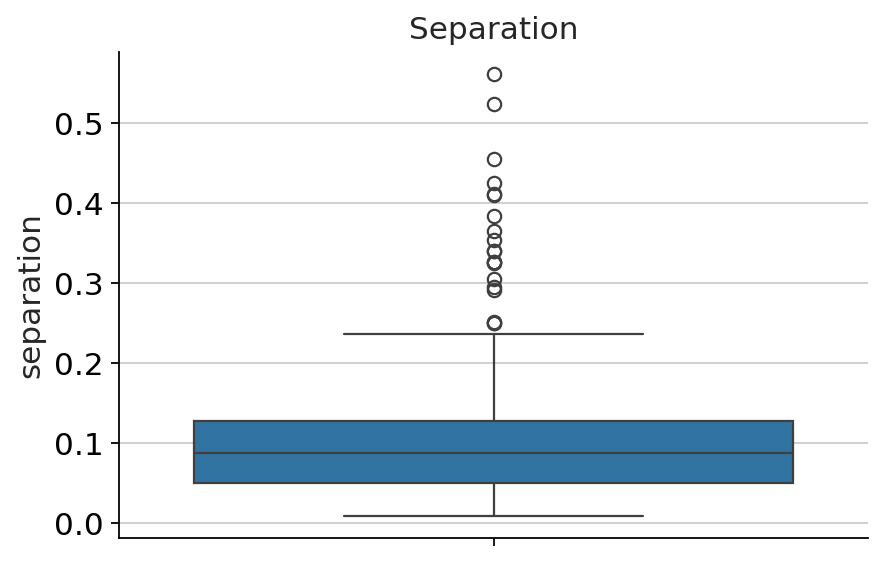

,separation
SEACell,
SEACell-0,0.098739
SEACell-1,0.022284
SEACell-10,0.127090
SEACell-100,0.094780
SEACell-101,0.119383


In [43]:
separation = SEACells.evaluate.separation(adata, 'X_pca')

plt.figure(figsize=(6,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

## 9. Hard assignment: downstream processing

* normalization and log-transformation
* dimensionality reduction: PCA and UMAP on SEACells

In [44]:
SEA_adata.layers['counts'] = SEA_adata.X.copy()

sc.pp.normalize_total(SEA_adata)
sc.pp.log1p(SEA_adata)
SEA_adata.layers['lognorm'] = SEA_adata.X.copy()

sc.pp.highly_variable_genes(SEA_adata, inplace=True)
sc.tl.pca(SEA_adata, use_highly_variable=True)
sc.pp.neighbors(SEA_adata, use_rep='X_pca')
sc.tl.umap(SEA_adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


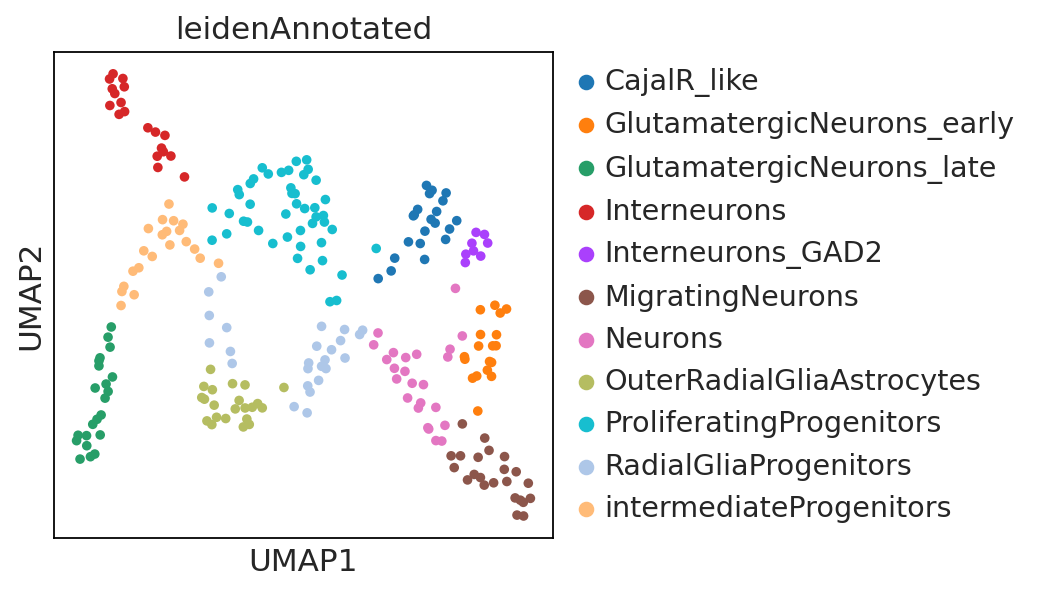

In [45]:
sc.pl.umap(SEA_adata, color=['leidenAnnotated'], s=75)

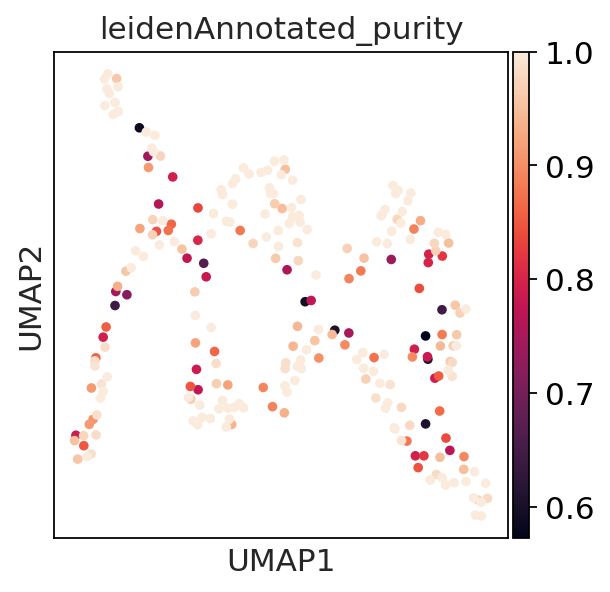

In [46]:
sc.pl.umap(SEA_adata, color=['leidenAnnotated_purity'], s=75)

In [47]:
SEA_adata.obs.columns

Index(['leidenAnnotated', 'leidenAnnotated_purity'], dtype='object')

----------------

# 10. Saving

## 10.1 Save SEACell Adata

In [53]:
SEA_adata

AnnData object with n_obs × n_vars = 249 × 33538
    obs: 'leidenAnnotated', 'leidenAnnotated_purity'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leidenAnnotated_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'counts', 'lognorm'
    obsp: 'distances', 'connectivities'

In [54]:
SEA_adata.X

<249x33538 sparse matrix of type '<class 'numpy.float64'>'
	with 3015391 stored elements in Compressed Sparse Row format>

In [55]:
SEA_adata.write(output_file)

## 10.2 Save in other formats

In [6]:
nb_fname = ipynbname.name()
nb_fname

'SEACellsCastaldi'

In [7]:
%%bash -s "$nb_fname"
jupyter nbconvert "$1".ipynb --to="python"
jupyter nbconvert "$1".ipynb --to="html"

[NbConvertApp] Converting notebook SEACellsCastaldi.ipynb to python
[NbConvertApp] Writing 12342 bytes to SEACellsCastaldi.py
[NbConvertApp] Converting notebook SEACellsCastaldi.ipynb to html
[NbConvertApp] Writing 4650178 bytes to SEACellsCastaldi.html


## 10.3 Finished computations: timestamp

In [56]:
print(datetime.now())

2025-02-25 21:50:18.287546
